# WTTA - Assignment #1 

## Inputs and Data Loading 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bem import steady_bem


# Inputs
R = 89.17       # Radius of rotor [m]
V_0 = 10.0      # Widx speed [m/s]
omega = 8.032   # Angular velocity of rotor [RPM]

# Read txt with blade data
df = pd.read_csv('data/bladedat.txt', sep='\t', names=['r', 'beta', 'c', 'thick'])

# RPM to rad/s
omega = omega*2*np.pi/60

# Question 1

In [22]:
number_of_theta_p = 20
number_of_lamda = 20

counter = 0
theta_p_list = np.linspace(-3, 4, number_of_theta_p)
lamda_list = np.linspace(5, 10, number_of_lamda)

# Initiliaze 2D matrices
P_out_matrix = np.zeros((number_of_theta_p, number_of_lamda))
Thrust_matrix = np.zeros((number_of_theta_p, number_of_lamda))
C_P_matrix = np.zeros((number_of_theta_p, number_of_lamda))
C_T_matrix = np.zeros((number_of_theta_p, number_of_lamda))

for i, theta_p in enumerate(theta_p_list):
    for j, lamda in enumerate(lamda_list):
        omega = lamda*V_0/R
        output_dict_total = steady_bem(R, V_0, omega, theta_p, lamda, df, model='Glauret', error=1e-6)
        P_out_matrix[i, j] = output_dict_total['P_out']
        Thrust_matrix[i, j] = output_dict_total['Thrust']
        C_P_matrix[i, j] = output_dict_total['C_P']
        C_T_matrix[i, j] = output_dict_total['C_T']

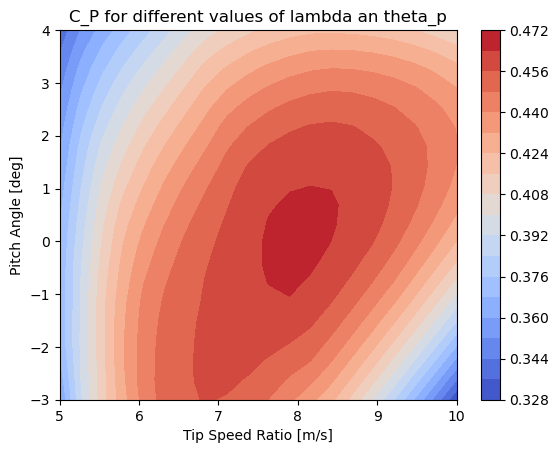

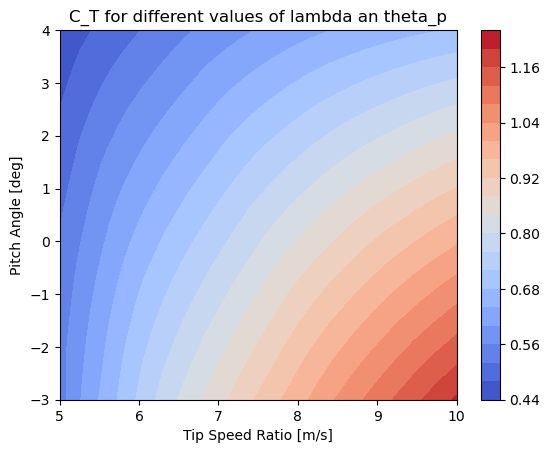

In [23]:
X, Y = np.meshgrid(lamda_list, theta_p_list)

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(X, Y, C_P_matrix, levels=number_of_theta_p, cmap='coolwarm')  # Should we add vmin=0.3, vmax=0.5 ??
fig.colorbar(cp)
ax.set_title('C_P for different values of lambda an theta_p')
ax.set_ylabel('Pitch Angle [deg]')
ax.set_xlabel('Tip Speed Ratio [m/s]')
plt.show()


fig, ax = plt.subplots(1, 1)
cp = ax.contourf(X, Y, C_T_matrix, levels=number_of_theta_p, cmap='coolwarm')  # Should we add vmin=0.3, vmax=0.5 ??
fig.colorbar(cp)
ax.set_title('C_T for different values of lambda an theta_p')
ax.set_ylabel('Pitch Angle [deg]')
ax.set_xlabel('Tip Speed Ratio [m/s]')
plt.show()

In [24]:
from bem import find_maxes_of_matrix

C_P_max, theta_p_for_C_P_max, lamda_for_C_P_max = find_maxes_of_matrix(C_P_matrix, theta_p_list, lamda_list)

print(f'Using {number_of_theta_p} theta_ps and {number_of_lamda} lamdas')
print(f'C_P_max = {C_P_max}')
print(f'theta_p_for_C_P_max = {theta_p_for_C_P_max}')
print(f'lamda_for_C_P_max = {lamda_for_C_P_max}')

Using 20 theta_ps and 20 lamdas
C_P_max = 0.4661481155575255
theta_p_for_C_P_max = -0.052631578947368585
lamda_for_C_P_max = 7.894736842105263


# Results we should be getting for Q1

|      | $C_P$ | $\lambda$ | $\theta_p$ |
|------|-----------|---------|-----------|
| Old  | 0.466     | 7.105   | 1.053     |
| New  | 0.466     | 7.949   | 0.051     |
| Prof | 0.466     | 8       | 0         |


# Question 2

In [25]:
import numpy as np
import pandas as pd
from bem import steady_bem_for_each_airfoil

# In case we need to run only Q2:
theta_p_for_C_P_max = 0.0512820512820511
lamda_for_C_P_max = 7.948717948717949

# Number of chords to test
number_of_c = 100

# Get dict for airfoil at r = 71.97 m 
df = pd.read_csv('data/bladedat.txt', sep='\t', names=['r', 'beta', 'c', 'thick'])
airfoil = df[df['r'].between(71, 73)].to_dict('records')[0]

# Get 'aoa' of airfoil at r = 71.97 m for values of 'theta_p' and 'lamda' that give 'C_P_max'
original_dict = steady_bem_for_each_airfoil(R, V_0, omega, theta_p_for_C_P_max, lamda_for_C_P_max, airfoil)
aoa_for_C_P_max = original_dict['aoa']

# Initiliaze arrays
c_arr = np.linspace(0, 4, number_of_c)
C_P_local_arr = np.zeros(number_of_c)
beta_arr = np.zeros(number_of_c)

# Use the 'aoa_for_C_P_max' 
for i, c in enumerate(c_arr):
    airfoil['c'] = c
    local_dict_2 = steady_bem_for_each_airfoil(R, V_0, omega, theta_p_for_C_P_max, lamda_for_C_P_max, airfoil, aoa=aoa_for_C_P_max)
    C_P_local_arr[i] = local_dict_2['C_P_local']
    beta_arr[i] = local_dict_2['beta']

# Print results
idx = np.argmax(C_P_local_arr)
print(f'           {"C_P_local":^10}{"beta":^10}{"c":^10}')
print(f'Original:  {original_dict["C_P_local"]:<10.5f}{"-1.11":<10}{"2.91":<10}')
print(f'Optimized: {C_P_local_arr[idx]:<10.5f}{beta_arr[idx]:<10.5f}{c_arr[idx]:<10.5f}')

           C_P_local    beta       c     
Original:  0.35795   -1.11     2.91      
Optimized: 0.40169   -0.00696  2.34343   


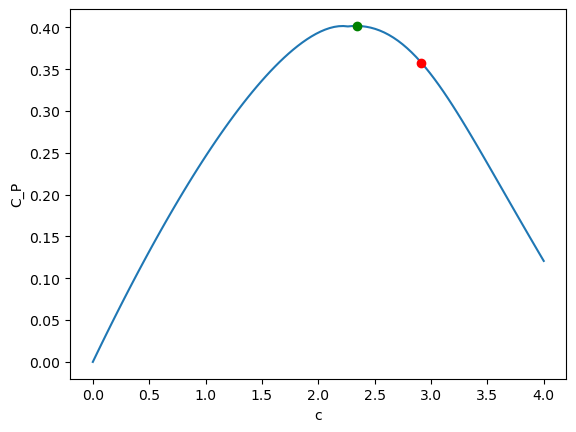

In [26]:
plt.plot(c_arr, C_P_local_arr)
plt.xlabel('c')
plt.ylabel('C_P')
plt.plot(2.91, 0.35795, 'ro')
plt.plot(c_arr[idx], C_P_local_arr[idx], 'go')

# Q3

In [27]:
P_mech = 10.64 * 1e6
A = np.pi*R**2
RHO = 1.225     # Air density [kg/m^3]

V_0_rated = (2*P_mech/(RHO*A*C_P_max))**(1/3)
omega_max = V_0_rated*lamda_for_C_P_max/R
print(f'V_0_rated = {V_0_rated}')
print(omega_max, 'rad/s')
print(omega_max*60/(2*np.pi), 'RPM') 

V_0_rated = 11.42636427508689
1.0185594572386758 rad/s
9.726526347151996 RPM


## It might have to start at V_0=cut_in_speed, V_0=cut_out_speed ???

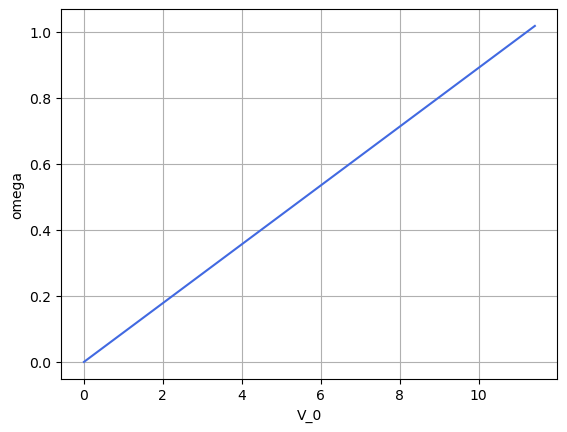

In [28]:
V_0_arr= np.linspace(0,V_0_rated,100)
omega_arr = lamda_for_C_P_max*V_0_arr/R
plt.plot(V_0_arr, omega_arr, color = 'royalblue')
plt.xlabel('V_0')
plt.ylabel('omega')
plt.grid()

# Q4

In [29]:
number_of_theta_p = 20
number_of_V_0 = 20

counter = 0
theta_p_list = np.linspace(0, 25, number_of_theta_p)
V_0_list = np.linspace(4, 25, number_of_V_0) # Cut-in and cut-out wind speed

theta_rated = np.zeros(number_of_V_0)
P_out_rated = np.zeros(number_of_V_0)
Thrust_rated = np.zeros(number_of_V_0)
C_P_rated = np.zeros(number_of_V_0)
C_T_rated = np.zeros(number_of_V_0)

for i, V_0_q4 in enumerate(V_0_list):
    # If V_0 <= V_0_rated use theta_p_for_C_P_max, lamda_for_C_P_max
    if V_0_q4 <= V_0_rated:
        omega = V_0_q4*lamda_for_C_P_max/R
        output_rated_dict = steady_bem(R, V_0_q4, omega, theta_p_for_C_P_max, lamda_for_C_P_max, df)
        P_out_rated[i] = output_rated_dict['P_out']
        Thrust_rated[i] = output_rated_dict['Thrust']
        C_P_rated[i] = output_rated_dict['C_P']
        C_T_rated[i] = output_rated_dict['C_T']
    else:
        # If V_0 > V_0_rated start pitching
        for j, theta_p in enumerate(theta_p_list):
            lamda = omega_max*R/V_0_q4
            output_rated_dict = steady_bem(R, V_0_q4, omega_max, theta_p, lamda, df)
            if output_rated_dict['P_out'] >= 10.64 * 1e3:
                theta_rated[i] = theta_p
                P_out_rated[i] = output_rated_dict['P_out']
                Thrust_rated[i] = output_rated_dict['Thrust']
                C_P_rated[i] = output_rated_dict['C_P']
                C_T_rated[i] = output_rated_dict['C_T']
                continue

ValueError: x and y must have same first dimension, but have shapes (20,) and (4,)

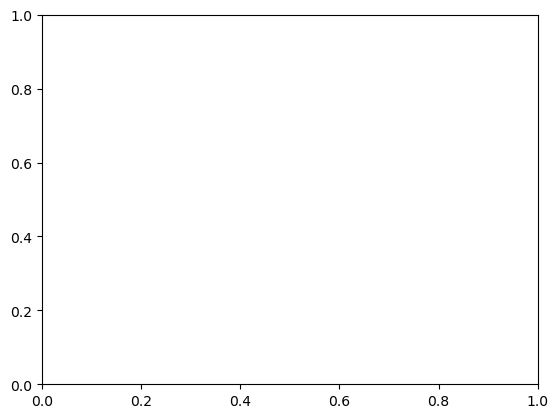

In [35]:
plt.plot(V_0_list, theta_rated, color = 'royalblue')
# plt.vlines(x=V_0_rated, ymin=0, ymax=10)
plt.xlabel('V_0')
plt.ylabel('theta_rated')
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (4,)

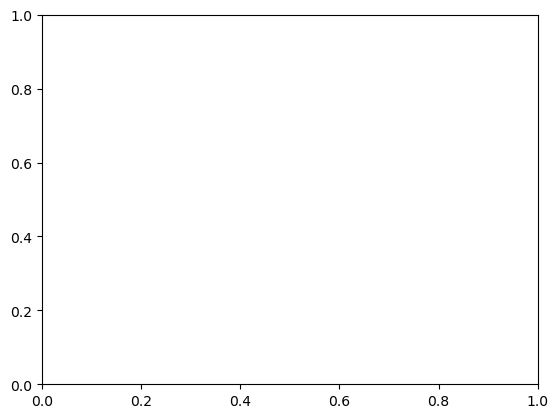

In [36]:
# Be carefull of W vs MW etc.

plt.plot(V_0_list, P_out_rated, color = 'royalblue')
# plt.vlines(x=V_0_rated, ymin=0, ymax=11750)
plt.xlabel('V_0')
plt.ylabel('P_out')
plt.grid()
plt.show()

plt.plot(V_0_list, Thrust_rated, color = 'royalblue')
# plt.vlines(x=V_0_rated, ymin=0, ymax=10)
plt.xlabel('V_0')
plt.ylabel('Thrust')
plt.grid()

plt.show()

plt.plot(V_0_list, C_P_rated, color = 'royalblue')
# plt.vlines(x=V_0_rated, ymin=0, ymax=0.4)
plt.xlabel('V_0')
plt.ylabel('C_P')
plt.grid()
plt.show()

plt.plot(V_0_list, C_T_rated, color = 'royalblue')
# plt.vlines(x=V_0_rated, ymin=0, ymax=0.4)
plt.xlabel('V_0')
plt.ylabel('C_T')
plt.grid()


# Question 5

In [32]:
number_of_theta_p = 150

counter = 0
theta_p_list = np.linspace(0, 25, number_of_theta_p)
V_0_q5_list = np.array([5, 9, 11, 20])
number_of_V_0 = len(V_0_q5_list)

omega_rated = np.zeros(number_of_V_0)
theta_rated = np.zeros(number_of_V_0)

P_out_rated = np.zeros(number_of_V_0)
Thrust_rated = np.zeros(number_of_V_0)
C_P_rated = np.zeros(number_of_V_0)
C_T_rated = np.zeros(number_of_V_0)

C_P_local_q5_list = []
C_T_local_q5_list = []

for i, V_0_q5 in enumerate(V_0_q5_list):
    # If V_0 <= V_0_rated use theta_p_for_C_P_max, lamda_for_C_P_max
    if V_0_q5 <= V_0_rated:
        omega = V_0_q5*lamda_for_C_P_max/R
        output_q5_dict = steady_bem(R, V_0_q5, omega, theta_p_for_C_P_max, lamda_for_C_P_max, df)
        omega_rated[i] = omega
        theta_rated[i] = theta_p_for_C_P_max

        P_out_rated[i] = output_q5_dict['P_out']
        Thrust_rated[i] = output_q5_dict['Thrust']
        C_P_rated[i] = output_q5_dict['C_P']
        C_T_rated[i] = output_q5_dict['C_T']
        C_P_local_q5_list.append(output_q5_dict['C_P_local_arr'])
        C_T_local_q5_list.append(output_q5_dict['C_T_local_arr'])
    else:
        # If V_0 > V_0_rated start pitching
        for j, theta_p in enumerate(theta_p_list):
            lamda = omega_max*R/V_0_q5
            output_q5_dict = steady_bem(R, V_0_q5, omega_max, theta_p, lamda, df)
            if output_q5_dict['P_out'] >= 10.64 * 1e3:
                omega_rated[i] = omega_max
                theta_rated[i] = theta_p
                P_out_rated[i] = output_q5_dict['P_out']
                Thrust_rated[i] = output_q5_dict['Thrust']
                C_P_rated[i] = output_q5_dict['C_P']
                C_T_rated[i] = output_q5_dict['C_T']
                C_P_local_q5_list.append(output_q5_dict['C_P_local_arr'])
                C_T_local_q5_list.append(output_q5_dict['C_T_local_arr'])
                continue

# rad/s -> rpm
omega_rated = omega_rated*60/(2*np.pi)

In [33]:
# omega_rated = omega_rated*60/(2*np.pi)
print('V_0 \t omega \t\t\t theta \t\t\t C_P \t\t\t C_T \t\t\t P_out \t\t\t Thrust')
for i in range(4):
    print(V_0_list[i], '\t', omega_rated[i], '\t', theta_rated[i], '\t', C_P_rated[i], '\t', C_T_rated[i], '\t', P_out_rated[i], '\t', Thrust_rated[i])

V_0 	 omega 			 theta 			 C_P 			 C_T 			 P_out 			 Thrust
4.0 	 4.25617725506919 	 0.0512820512820511 	 0.46619198239477433 	 0.8349496342623864 	 891.5964122796123 	 319.3697560041362
5.105263157894737 	 7.661119059124542 	 0.0512820512820511 	 0.4661919823947743 	 0.8349496342623864 	 5199.790276414699 	 1034.7580094534014
6.210526315789474 	 9.363589961152217 	 0.0512820512820511 	 0.4661919823947744 	 0.8349496342623863 	 9493.718597953311 	 1545.7496190600193
7.315789473684211 	 9.726526347151996 	 17.114093959731544 	 0.08894093172749443 	 0.11263130448250779 	 10886.421886631415 	 689.3068660417338


In [34]:
df_q5 = pd.DataFrame({
    'V_0': V_0_list,
    'omega': omega_rated,
    'theta': theta_rated,
    'C_P': C_P_rated,
    'C_T': C_T_rated,
    'P_out': P_out_rated,
    'Thrust': Thrust_rated
    # 'C_P_local_arr': C_P_local_q5_list,
    # 'C_T_local_arr': C_T_local_q5_list
})
df_q5.to_excel('Q5_BEM_results.xlsx')

ValueError: All arrays must be of the same length

In [ ]:
C_P_local_q5_list

[array([-0.02710859, -0.07197577,  0.04453627,  0.43009345,  0.54208148,
         0.54218638,  0.54159891,  0.53943522,  0.53414263,  0.52426266,
         0.50336693,  0.49243492,  0.47890686,  0.4421344 ,  0.38847376,
         0.30973096,  0.17870263,  0.        ]),
 array([-0.02710859, -0.07197577,  0.04453627,  0.43009345,  0.54208148,
         0.54218638,  0.54159891,  0.53943522,  0.53414263,  0.52426266,
         0.50336693,  0.49243492,  0.47890686,  0.4421344 ,  0.38847376,
         0.30973096,  0.17870263,  0.        ]),
 array([-0.02710859, -0.07197577,  0.04453627,  0.43009345,  0.54208148,
         0.54218638,  0.54159891,  0.53943522,  0.53414263,  0.52426266,
         0.50336693,  0.49243492,  0.47890686,  0.4421344 ,  0.38847376,
         0.30973096,  0.17870263,  0.        ]),
 array([-0.00871443, -0.00156782,  0.08700549,  0.11210102,  0.20820312,
         0.38670332,  0.43723769,  0.43298465,  0.40938445,  0.37991498,
         0.34847242,  0.33769877,  0.32640042,  0.

## Read and Save Ashes data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

for speed in [5, 9, 11, 20]:
    df_ashes = pd.read_table(
        f"ashes/Speed_{speed}/Sensor Rotor.txt",
        delimiter='\t',
        usecols=["Time [s]", "Power (aero) [k W]", "Torque (aero) [k Nm]", "Thrust (aero) [k N]", "Power coef. (CP) [%]", "Thrust coef. (CT) [%]"],
        skiprows=11
    )
    df_ashes = df_ashes.rename(columns={
        'Time [s]': 'Time',
        'Power (aero) [k W]': 'Power',
        'Torque (aero) [k Nm]': 'Torque',
        'Thrust (aero) [k N]': 'Thrust',
        'Power coef. (CP) [%]': 'CP',
        'Thrust coef. (CT) [%]': 'CT',
    })

    # Drop the first 7 rows with the MEAN etc.
    df_ashes.iloc[1:5].to_excel(f'Speed_{speed}_Ashes_Mean.xlsx')